In [1]:
import torch
import torch.nn
import torch.optim

import GraphX as gx
import ConnectionGraphX as cgx
import numpy as np
import networkx as nx
import scipy as sp

import ConnectionNetworkX as cnx

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm


matplotlib.get_backend() =  module://matplotlib_inline.backend_inline


In [2]:
'''
phi,c: |V|d x 1
B: |E|d x |V|d      Connection incidence matrix
w: |E| x 1          Edge weights
c: |V|d x 1         c = alpha-beta; i.e. difference of densities
'''
def loss_fn(phi, B, w, c, alpha):
    loss0 = -torch.sum(phi*c)
    
    loss1 = torch.matmul(B, phi).reshape((w.shape[0],-1))
    loss1 = torch.linalg.norm(loss1, dim=1)
    loss1 = loss1 - w
    loss1 = torch.nn.ReLU()(loss1)
    loss1 = torch.sum(loss1**2)
    
    loss = loss0 + (0.5/alpha)*loss1
    return loss

In [3]:
def optimize(B, w, c, alpha, learning_rate, n_epochs, phi0 = None, print_freq=10):
    if phi0 is None:
        phi = torch.randn(B.shape[1], 1, requires_grad=True)
    else:
        phi = torch.tensor(phi0, requires_grad=True)
    optimizer = torch.optim.Adam([phi], lr=learning_rate)
    for epoch in range(n_epochs):
        # Compute loss
        loss = loss_fn(phi, B, w, c, alpha)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % print_freq == 0:
            print(f"epoch: {epoch}, loss: {loss:>7f}")
    return phi

# Define B, w and c

In [4]:
NODES = 2
EDGES = 1
seed = 42

a = nx.adjacency_matrix(nx.gnm_random_graph(NODES, EDGES, seed=seed))

# a = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
g = gx.GraphX(sp.sparse.csr_matrix.toarray(a))

DIM_CONNECTION = 2
h = cgx.ConnectionGraphX(sp.sparse.csr_matrix.toarray(a), DIM_CONNECTION)

In [5]:
B = h.connectionIncidenceMatrix.T.astype('float32')
w = np.ones(B.shape[0]//DIM_CONNECTION).astype('float32')

np.random.seed(42)
def rand_prob_mass(n, d):
    mu = np.random.uniform(0, 1, (n, d)).astype('float32')
    mu = mu/(mu.sum(axis=0)[None,:])
    mu = mu.flatten()[:,None]
    return mu

mu = rand_prob_mass(h.nNodes, DIM_CONNECTION)
nu = rand_prob_mass(h.nNodes, DIM_CONNECTION)
c = (mu - nu)

In [6]:
c.reshape((h.nNodes, DIM_CONNECTION))

array([[-0.39023045,  0.46100134],
       [ 0.39023048, -0.46100134]], dtype=float32)

In [7]:
c.reshape((h.nNodes, DIM_CONNECTION)).sum(axis=0)

array([2.9802322e-08, 0.0000000e+00], dtype=float32)

# Check feasibility of B

In [8]:
c_sol, residuals, _, _ = np.linalg.lstsq(B.T, c.flatten())

/var/folders/0d/431gq5hn0_ngj8qfl5bt02680000gn/T/ipykernel_22608/186593914.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c_sol, residuals, _, _ = np.linalg.lstsq(B.T, c.flatten())


In [9]:
residuals

array([4.440892e-16], dtype=float32)

In [10]:
np.linalg.norm(c.flatten() - B.T.dot(c_sol).flatten())

2.9802322e-08

In [11]:
learning_rate = 0.01
alpha = 1e-5
n_epochs = 10000

B = torch.tensor(B)
w = torch.tensor(w)
c = torch.tensor(c)

optimize(B, w, c, alpha, learning_rate, n_epochs)

epoch: 0, loss: 1928.667480
epoch: 10, loss: 0.063138
epoch: 20, loss: 0.067775
epoch: 30, loss: 0.069541
epoch: 40, loss: 0.070223
epoch: 50, loss: 0.070474
epoch: 60, loss: 0.070555
epoch: 70, loss: 0.070568
epoch: 80, loss: 0.070554
epoch: 90, loss: 0.070528
epoch: 100, loss: 0.070497
epoch: 110, loss: 0.070464
epoch: 120, loss: 0.070427
epoch: 130, loss: 0.070389
epoch: 140, loss: 0.070350
epoch: 150, loss: 0.070309
epoch: 160, loss: 0.070266
epoch: 170, loss: 0.070222
epoch: 180, loss: 0.070177
epoch: 190, loss: 0.070130
epoch: 200, loss: 0.070081
epoch: 210, loss: 0.070032
epoch: 220, loss: 0.069981
epoch: 230, loss: 0.069929
epoch: 240, loss: 0.069875
epoch: 250, loss: 0.069821
epoch: 260, loss: 0.069765
epoch: 270, loss: 0.069707
epoch: 280, loss: 0.069649
epoch: 290, loss: 0.069589
epoch: 300, loss: 0.069528
epoch: 310, loss: 0.069466
epoch: 320, loss: 0.069403
epoch: 330, loss: 0.069339
epoch: 340, loss: 0.069273
epoch: 350, loss: 0.069206
epoch: 360, loss: 0.069138
epoch: 37

tensor([[0.6495],
        [1.5263],
        [1.2129],
        [0.8238]], requires_grad=True)

# Working example

In [12]:
w = np.ones(1)
d = 2
sigma = np.eye(d)
B = np.block([np.sqrt(w)*np.eye(d), -np.sqrt(w)*sigma])

np.random.seed(42)
mu = np.random.uniform(0, 1, d)
mu = mu/mu.sum()
nu = np.random.uniform(0, 1, d)
nu = nu/nu.sum()
c = mu-nu
optim_val = np.linalg.norm(c)
optim_phi = c/np.linalg.norm(c)
c = np.block([c,-c])
c = c.reshape((2*d,1))

phi0 = np.block([optim_phi,optim_phi*0]).reshape(2*d,1)

print(B)
print(w)
print(c)
print(phi0)
print(optim_val)

B = torch.tensor(B.astype('float32'))
w = torch.tensor(w.astype('float32'))
c = torch.tensor(c.astype('float32'))
phi0 = phi0.astype('float32')

[[ 1.  0. -1. -0.]
 [ 0.  1. -0. -1.]]
[1.]
[[-0.26748401]
 [ 0.26748401]
 [ 0.26748401]
 [-0.26748401]]
[[-0.70710678]
 [ 0.70710678]
 [-0.        ]
 [ 0.        ]]
0.37827952162613965


# Solve Beckmann - connection problem

In [13]:
learning_rate = 0.001
alpha = 1e-1
n_epochs = 10000

In [14]:
optimize(B, w, c, alpha, learning_rate, n_epochs, phi0=phi0)

epoch: 0, loss: -0.378280
epoch: 10, loss: -0.384847
epoch: 20, loss: -0.385245
epoch: 30, loss: -0.385234
epoch: 40, loss: -0.385434
epoch: 50, loss: -0.385405
epoch: 60, loss: -0.385434
epoch: 70, loss: -0.385430
epoch: 80, loss: -0.385434
epoch: 90, loss: -0.385434
epoch: 100, loss: -0.385434
epoch: 110, loss: -0.385434
epoch: 120, loss: -0.385434
epoch: 130, loss: -0.385434
epoch: 140, loss: -0.385434
epoch: 150, loss: -0.385434
epoch: 160, loss: -0.385434
epoch: 170, loss: -0.385434
epoch: 180, loss: -0.385434
epoch: 190, loss: -0.385434
epoch: 200, loss: -0.385434
epoch: 210, loss: -0.385434
epoch: 220, loss: -0.385434
epoch: 230, loss: -0.385434
epoch: 240, loss: -0.385434
epoch: 250, loss: -0.385434
epoch: 260, loss: -0.385434
epoch: 270, loss: -0.385434
epoch: 280, loss: -0.385434
epoch: 290, loss: -0.385434
epoch: 300, loss: -0.385434
epoch: 310, loss: -0.385434
epoch: 320, loss: -0.385434
epoch: 330, loss: -0.385434
epoch: 340, loss: -0.385434
epoch: 350, loss: -0.385434
epo

tensor([[-0.7205],
        [ 0.7205],
        [ 0.0134],
        [-0.0134]], requires_grad=True)

# Attempt Beckmann on Puppet Connection Graph

Initialize the puppet connection graph

In [15]:
p = "/Users/sawyerjack/IdeaProjects/project_data/PuppetsData"

N_PUPPET_IMAGES = 500
NEAREST_NEIGHBORS = 7
INTRINSIC_DIMENSION = 2

puppetGraph = cnx.cnxFromImageDirectory(p, INTRINSIC_DIMENSION, k=NEAREST_NEIGHBORS, nImages=N_PUPPET_IMAGES)


X.shape =  (8100, 100)
local_opts['k_nn0'] = 175 is created.
Options provided:
local_opts:
{
    "Atilde_method": "LDLE_1",
    "N": 100,
    "U_method": "k_nn",
    "algo": "LPCA",
    "alpha": 1,
    "debug": true,
    "delta": 0.9,
    "gl_type": "unnorm",
    "k": 7,
    "k_nn": 49,
    "k_nn0": 175,
    "k_tune": 7,
    "lambda1_decay": 0.75,
    "lambda1_init": 8,
    "lambda1_min": 0.001,
    "max_iter": 300,
    "max_sparsity": 0.9,
    "metric": "euclidean",
    "n_proc": 6,
    "p": 0.99,
    "power": 5,
    "pp_n_thresh": 32,
    "radius": 0.5,
    "reg": 0.0,
    "scale_by": "gamma",
    "tau": 50,
    "to_postprocess": true,
    "verbose": true
}
intermed_opts:
{
    "algo": "best",
    "debug": true,
    "eta_max": 25,
    "eta_min": 5,
    "len_S_thresh": 256,
    "local_algo": "LPCA",
    "metric": "euclidean",
    "n_proc": 6,
    "n_times": 4,
    "verbose": true
}
global_opts:
{
    "add_dim": false,
    "align_transform": "rigid",
    "align_w_parent_only": true,
  

100%|██████████| 500/500 [00:08<00:00, 62.16it/s] 


Proportion of edges which were removed due to remoteness:  0.04918032786885246
[0.61908112 0.600488   0.57254034 0.56736853 0.528783   0.46472219
 0.43431158 0.4059547  0.36433494 0.28289545]
MOST LIKELY INCONSISTENT: |lambda_min| >= 1e-8. 


Setting up B, c, w for the puppet graph

In [16]:
puppetB = puppetGraph.connectionIncidenceMatrix.T.astype('float32')
puppetW = np.ones(puppetB.shape[0]//INTRINSIC_DIMENSION).astype('float32')

np.random.seed(42)

#puppetMu = rand_prob_mass(puppetGraph.nNodes, INTRINSIC_DIMENSION)
#puppetNu = rand_prob_mass(puppetGraph.nNodes, INTRINSIC_DIMENSION)

puppetMu = np.zeros((puppetGraph.nNodes * INTRINSIC_DIMENSION,1))
puppetMu[0:2, :] = [[1],[1]]
puppetNu = np.zeros((puppetGraph.nNodes * INTRINSIC_DIMENSION,1))
puppetNu[2:4, :] = [[1],[1]]

puppetC = (puppetMu - puppetNu)

puppetC.reshape((puppetGraph.nNodes, INTRINSIC_DIMENSION))
puppetC.reshape((puppetGraph.nNodes, INTRINSIC_DIMENSION)).sum(axis=0)


array([0., 0.])

Checking Feasibility - looks good

In [17]:
print(type(puppetC))
print(type(puppetB))
c_sol, residuals, _, _ = np.linalg.lstsq(sp.sparse.lil_matrix.toarray(puppetB.T), puppetC)

# I didn't rename the dummy variables here- caution.

np.linalg.norm(puppetC.flatten() - puppetB.T.dot(c_sol).flatten())
#np.linalg.norm(c_sol)


<class 'numpy.ndarray'>
<class 'scipy.sparse._lil.lil_matrix'>


/var/folders/0d/431gq5hn0_ngj8qfl5bt02680000gn/T/ipykernel_22608/1989130843.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c_sol, residuals, _, _ = np.linalg.lstsq(sp.sparse.lil_matrix.toarray(puppetB.T), puppetC)


7.869927538493496e-15

Attempt to plug into the optimization methods

In [18]:
learning_rate = 0.1
alpha = 1e-5
n_epochs = 10000

B = torch.tensor(sp.sparse.lil_matrix.toarray(puppetB))
w = torch.tensor(puppetW)
c = torch.tensor(puppetC)

puppetPhi = optimize(B, w, c, alpha, learning_rate, n_epochs)

epoch: 0, loss: 124274375.303661
epoch: 10, loss: 4992243.100296
epoch: 20, loss: 455214.935211
epoch: 30, loss: 99217.827784
epoch: 40, loss: 13225.922566
epoch: 50, loss: 1529.157590
epoch: 60, loss: 145.816004
epoch: 70, loss: 1.612055
epoch: 80, loss: 1.580577
epoch: 90, loss: 1.385402
epoch: 100, loss: 1.384019
epoch: 110, loss: 1.383385
epoch: 120, loss: 1.383020
epoch: 130, loss: 1.382748
epoch: 140, loss: 1.382505
epoch: 150, loss: 1.382266
epoch: 160, loss: 1.382024
epoch: 170, loss: 1.381775
epoch: 180, loss: 1.381520
epoch: 190, loss: 1.381256
epoch: 200, loss: 1.380985
epoch: 210, loss: 1.380706
epoch: 220, loss: 1.380420
epoch: 230, loss: 1.380127
epoch: 240, loss: 1.379826
epoch: 250, loss: 1.379518
epoch: 260, loss: 1.379203
epoch: 270, loss: 1.378882
epoch: 280, loss: 1.378553
epoch: 290, loss: 1.378218
epoch: 300, loss: 1.377876
epoch: 310, loss: 1.377527
epoch: 320, loss: 1.377171
epoch: 330, loss: 1.376810
epoch: 340, loss: 1.376441
epoch: 350, loss: 1.376066
epoch: 

In [19]:
np.linalg.norm(puppetPhi.detach().numpy())

12.630581

Doing some post-hoc illustration- want to see "active edges"

In [20]:
#print(c_sol.shape)

#for edge in range(1846):
#    if abs(c_sol[edge]) < TOLERANCE:
#        c_sol[edge] = 0

# with np.printoptions(threshold=np.inf):
    # print(c_sol)


In [21]:
import puppets_data
Y_, labelsMat_, _ = puppets_data.puppets_data(p)

X.shape =  (8100, 100)


In [22]:
from umap import UMAP
umap_obj = UMAP(n_neighbors=13, min_dist=0.5, n_components=3, random_state=42)
umap_puppetGraph_embedding = umap_obj.fit_transform(puppetGraph.imageData)



In [23]:
umap_puppetGraph_embedding[0,2]

7.555727

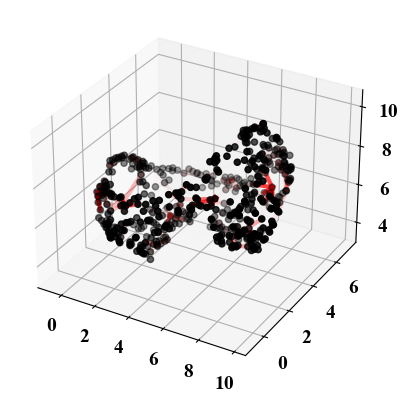

In [24]:
from mpl_toolkits.mplot3d.art3d import Line3D

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# ax.set_xlim((-1.1, 1.1))
# ax.set_ylim((-1.1, 1.1))
# ax.set_zlim((-1.1, 1.1))

nodeData = nx.kamada_kawai_layout(puppetGraph)

TOLERANCE = 1e-4
MAX = np.amax(abs(c_sol))

for edgeIndex, edge in zip(range(puppetGraph.nEdges), list(puppetGraph.edges())):

    if abs(c_sol[edgeIndex])[0] > TOLERANCE:
        col=(1, 0, 0, abs(c_sol[edgeIndex])[0]/MAX)
        z = 3
    else:
        #col="tab:blue"
        col=(1,1,1,0)
        z = 1

    fromNode = edge[0]
    toNode = edge[1]
    centerFromNode = umap_puppetGraph_embedding[fromNode, :]
    centerToNode = umap_puppetGraph_embedding[toNode, :]

    ax.plot((centerFromNode[0], centerToNode[0]), (centerFromNode[1], centerToNode[1]), (centerFromNode[2], centerToNode[2]), color=col, lw=3)
    # edgeLabel = Line3D((centerFromNode[0], centerToNode[0]), (centerFromNode[1], centerToNode[1]), (centerFromNode[2], centerToNode[2]), color=col, lw=3)
    # edgeLabel.zorder = z
    # ax.add_line(edgeLabel)

# for node in tqdm(list(range(2, N_PUPPET_IMAGES)) + [0, 1]):
#     center = nodeData[node][0], nodeData[node][1]
#     if node in [0,1]:
#         col="tab:red"
#         zNode=2
#         r=1e-1
#         #ax.text(center[0], center[1], str(node+1))
#     else:
#         col="tab:blue"
#         zNode=1
#         r=2e-2
#     nodeLabel = matplotlib.patches.Circle(center, radius=r, color=col, zorder=zNode)
#     ax.add_patch(nodeLabel)

nodeColor = np.zeros(N_PUPPET_IMAGES)
nodeColor[0:2] = 1

ax.scatter(*umap_puppetGraph_embedding.T, c='k', marker='o')

ax.scatter(*umap_puppetGraph_embedding[0:2,:].T, c='r', s=30, marker='*')
plt.show()
# Want to color "active" edges red. WIP.
# Noticed that CNX has an issue- not properly removing the remote edges. Zeroing the Connection incidence is not enough.


In [25]:
print(puppetGraph.nEdges * 2)
print(c_sol.shape)
print(puppetPhi.detach().numpy().shape)



3660
(3660, 1)
(1000, 1)


In [26]:
np.amax(c_sol)

0.2570988432844522